# TCGA dataset exploratory data analysis

The data is downloaded from TCGA database (https://portal.gdc.cancer.gov/).

In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

AUGMENTATION = 80

# Specify the path to the parent directory containing the folders to iterate through
parent_dir = "../data/data-tcga/samples"
sample_sheet_file = "../data/data-tcga/gdc_sample_sheet.2023-05-20.tsv"
clinical_file = "../data/data-tcga/clinical.tsv"

all_data_file_path = "all_data.pkl"
all_labels_file_path = "all_labels.pkl"
all_data_columns_file_path = "all_data_columns.pkl"
ignored_tissues_file_path = "ignored_tissues_list.pkl"
class_mapping_file_path = "class_mapping.pkl"
encoder_file = f"encoder_{AUGMENTATION}.pkl"
model_file_name = f"xgboost-{AUGMENTATION}.model"

In [2]:
# class mapping
class_mapping = {}
# ignore unknown tissues
ignored_tissues = []

# load the files if they exist

if os.path.exists(class_mapping_file_path):

    # load the list of ignored tissues from a pickel file
    with open(ignored_tissues_file_path, 'rb') as f: 
        ignored_tissues = pickle.load(f)

    # load a dataframe with the labels of each sample from a pickel file
    with open(class_mapping_file_path, 'rb') as f: 
        class_mapping = pickle.load(f)

In [3]:
# verify if the all_data_file_path exist or not
if not os.path.exists(all_data_file_path):
    
    # read sample sheet file and clinical file into the memory
    sample_sheet = pd.read_csv(sample_sheet_file, delimiter="\t")
    clinical_sheet = pd.read_csv(clinical_file, delimiter="\t")
    
    all_data = []
    all_labels = []

    # Iterate through all folders in the parent directory
    for folder in os.listdir(parent_dir):
        # Create the full path to the folder
        folder_path = os.path.join(parent_dir, folder)
        # Check if the item in the directory is a folder
        if os.path.isdir(folder_path):

            # try to extract the cancer tissue first, if possible
            row = sample_sheet[ sample_sheet['File ID'] == folder ]
            
            # confirm that there is at most 1 row extracted for the current folder
            assert(row.shape[0] < 2)

            # access the value stored in Case ID
            case_id = row['Case ID'].values[0]

            case_id_clinical = clinical_sheet[clinical_sheet['case_submitter_id'] == case_id]
            if len(case_id_clinical['tissue_or_organ_of_origin'].values) == 0:
                continue

            tissue_organ_origin = case_id_clinical['tissue_or_organ_of_origin'].values[0]

            # skipping the labels stored in ignored_tissue list:
            if tissue_organ_origin in ignored_tissues:
                continue

            # storing the labels in a dictionary
            if tissue_organ_origin not in class_mapping:
                new_label = None
                # try to find an already seen label in tissue_organ_origin automatically
                for label in all_labels:
                    # converting label from dataframe to string
                    label = label[0][0]
                    if label in tissue_organ_origin.lower():
                        new_label = label
                        break
                # manual user input required to determine the label
                if new_label is None:
                    print(f'New tissue origin found: \"{tissue_organ_origin}\". \nEnter the label for it or leave it empty to add it to the ignore list: ')
                    new_label = input()

                    if new_label == "":
                        ignored_tissues.append(tissue_organ_origin)
                        continue
                class_mapping[tissue_organ_origin] = new_label

            # tissue extracted successfully!
            all_labels.append(pd.DataFrame([class_mapping[tissue_organ_origin]]))


            # extract the gene counts

            # Get a list of all .tsv files in the folder
            tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.tsv')]
            # If there is exactly one .tsv file in the folder, proceed
            if len(tsv_files) == 1:
                # Create the full path to the .tsv file
                tsv_path = os.path.join(folder_path, tsv_files[0])
                
                # Open the .tsv file and count the number of lines starting with "ENSG"
                columns = []
                counts = []
                with open(tsv_path, 'r') as tsv_file:
                    for line in tsv_file:
                        if line.startswith("ENSG"):

                            split_line = line.split('\t')

                            gene_name = split_line[1]
                            tpm = split_line[6]
                            columns.append(gene_name)
                            counts.append(tpm)

                row_df = pd.DataFrame(counts, dtype=np.float32)
                all_data.append(row_df)

    print("Tissue and counts extracted sucessfully!")

    all_data = pd.concat(all_data, axis=1, ignore_index=True).transpose()
    all_data.columns = columns
    all_labels = pd.concat(all_labels, axis=0, ignore_index=True)

    # store the count matrices and labels into pickle files
    with open(all_data_file_path, 'wb') as all_data_pckl:
        pickle.dump(all_data, all_data_pckl)
    with open(all_labels_file_path, 'wb') as all_labels_pckl:
        pickle.dump(all_labels, all_labels_pckl)
    

else: # .pkl file exists, load everything from it to skip processing

    with open(all_data_file_path, 'rb') as all_data_pckl:
        all_data = pickle.load(all_data_pckl)
    with open(all_labels_file_path, 'rb') as all_labels_pckl:
        all_labels = pickle.load(all_labels_pckl)

In [4]:
# save the files if they do not exist
if not os.path.exists(class_mapping_file_path):
    
    # save the list of ignored tissues in a pickel file
    with open(ignored_tissues_file_path, 'wb') as f: 
        pickle.dump(ignored_tissues, f)

    # save a dataframe with the labels of each sample in a pickel file
    with open(class_mapping_file_path, 'wb') as f: 
        pickle.dump(class_mapping, f)

In [5]:
del class_mapping
del ignored_tissues

In [6]:
# save the all_data columns in a list
all_data_columns = all_data.columns
print("all_data_columns: ", all_data_columns)
print(f'Total gene count: {len(all_data_columns)}')
unique_columns = list(set(all_data_columns))
print(f'Unique gene count: {len(unique_columns)}')

# save the columns to use it later to organize the columns of different dataset
with open(all_data_columns_file_path, 'wb') as all_data_columns_pckl: 
    pickle.dump(unique_columns, all_data_columns_pckl)

all_data_columns:  Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA',
       ...
       'AL451106.1', 'AC092910.4', 'AC073611.1', 'AC136977.1', 'AC078856.1',
       'AC008763.4', 'AL592295.6', 'AC006486.3', 'AL391628.1', 'AP006621.6'],
      dtype='object', length=60660)
Total gene count: 60660
Unique gene count: 59427


The column names are genes as expected, the problem now is that we have duplicated columns and xgboost will complain. The solution will be adding the counts of columns with the same gene name.

In [7]:
all_data_unique = all_data.groupby(all_data.columns, axis=1).sum()
print(f'Total gene count: {len(all_data_unique.columns)}')
unique_columns = len(set(all_data_unique.columns))
print(f'Unique gene count: {unique_columns}')
del all_data

Total gene count: 59427
Unique gene count: 59427


Now we are ready to train, since all columns have a unique name

**Training xgBoost Model**

In [8]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [9]:
# Data augmentation

random_percentage = AUGMENTATION / 100.0

all_data_augmented = all_data_unique
all_labels_augmented = all_labels
del all_labels

if random_percentage != 0:
    # set the seed for reproducibility
    np.random.seed(42)

    # mask is multiplicative:
    #   - wherever there is 1 the original number doesn't change
    #   - wherever there is 0 the original number is "deleted" by being set to zero
    
    # copy all_data dataset

    all_data_copy = all_data_unique.copy()
    # print("Initial data matrix copy BEFORE augmentation:")
    # print(all_data_copy)
    
    zero_out_mask = np.random.rand(all_data_copy.shape[0], all_data_copy.shape[1])
    # print("Original float random mask matrix:")
    # print(zero_out_mask)
    zero_out_mask[ zero_out_mask > random_percentage ] = 1
    zero_out_mask[ zero_out_mask <= random_percentage ] = 0
    # print("Final boolean random matrix:")
    # print(zero_out_mask)

    all_data_copy = all_data_copy * zero_out_mask
    del zero_out_mask
    # print("Final data matrix copy AFTER augmentation:")
    # print(all_data_copy)

    # all_data_augmented = all_data_copy
    # all_labels_augmented = all_labels

    all_data_augmented = pd.concat([all_data_unique, all_data_copy], axis = 0)
    print("Shape of all_data_augmented dataset: ", all_data_augmented.shape)

    all_labels_augmented = pd.concat([all_labels_augmented, all_labels_augmented], axis = 0)
    print("Shape of all_labels_augmented dataset: ", all_labels_augmented.shape)

    del all_data_copy
    


Shape of all_data_augmented dataset:  (17336, 59427)
Shape of all_labels_augmented dataset:  (17336, 1)


In [10]:
# Free up memory before training
del all_data_unique
# del clinical_sheet
# del class_mapping
# del ignored_tissues
del all_data_columns
del unique_columns

In [11]:
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels_augmented[0].to_list())
del all_labels_augmented

#Split dataset into training and validation sets
all_data_train, all_data_validation, all_labels_encoded_train, all_labels_encoded_validation = \
    train_test_split(all_data_augmented, all_labels_encoded, test_size=0.2, random_state=42)

del all_data_augmented
del all_labels_encoded

# duplicated = all_data_train.columns[all_data_train.columns.duplicated()]
# print(duplicated)

print("Training the model...")

model_train : xgb.XGBClassifier = xgb.XGBClassifier()
model_train.fit(all_data_train, all_labels_encoded_train)

print("Done.")

Training the model...
Done.


In [12]:
#saving the label encoder for later use
with open(encoder_file, 'wb') as f:
    pickle.dump(label_encoder, f)

Verifying accuracy...
Accuracy of the train: 100.0000%
Accuracy of the validation: 98.3852%
['bladder' 'brain' 'breast' 'colon' 'kidney' 'liver' 'lung' 'pancreas'
 'prostate' 'skin']
[[139   0   3   0   0   0  12   1   0   0]
 [  0 328   0   0   0   0   0   0   0   1]
 [  1   0 606   0   0   0   1   0   0   1]
 [  0   0   0 295   0   0   0   0   0   0]
 [  2   1   1   0 595   0   0   0   0   1]
 [  3   1   1   0   1 182   0   1   0   0]
 [  1   0   6   0   1   0 715   0   0   0]
 [  0   0   1   4   0   0   4 167   0   0]
 [  0   0   1   0   2   0   0   0 213   0]
 [  0   0   2   0   1   0   1   0   0 172]]


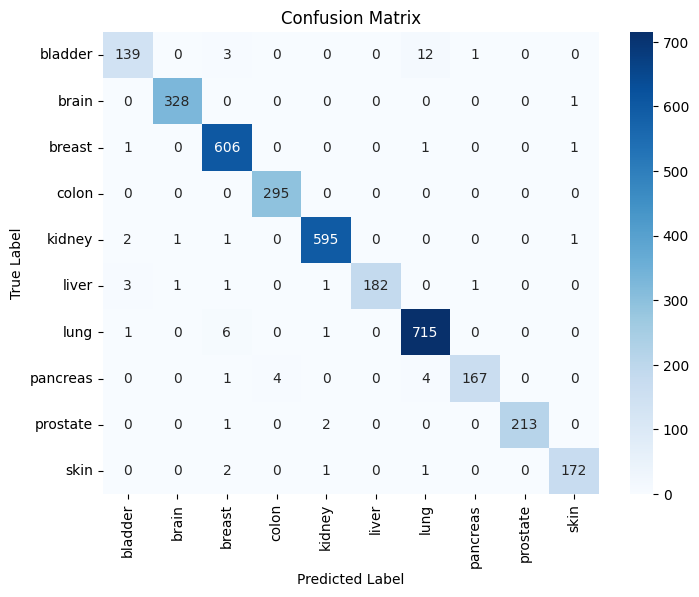

In [13]:
print("Verifying accuracy...")
# verify accuracy of the train data
pred_train = model_train.predict(all_data_train)

accuracy = accuracy_score(pred_train, all_labels_encoded_train)
print("Accuracy of the train: %.4f%%" % (accuracy * 100.0))

# verify accuracy of the validation data
pred_validation = model_train.predict(all_data_validation)

accuracy = accuracy_score(pred_validation, all_labels_encoded_validation)
print("Accuracy of the validation: %.4f%%" % (accuracy * 100.0))

print(label_encoder.classes_)
confusion = sklearn.metrics.confusion_matrix(all_labels_encoded_validation, pred_validation)
print(confusion)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have already calculated the confusion matrix
confusion = confusion_matrix(all_labels_encoded_validation, pred_validation)

# Calculate precision
precision = precision_score(all_labels_encoded_validation, pred_validation, average='macro')

# Calculate recall
recall = recall_score(all_labels_encoded_validation, pred_validation, average='macro')

# Calculate F1 score
f1 = f1_score(all_labels_encoded_validation, pred_validation, average='macro')

# Print the results
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Precision: 0.9847
Recall: 0.9745
F1 Score: 0.9794


In [15]:
#saving the model for later use
with open(model_file_name, 'wb') as file_model:
    pickle.dump(model_train, file_model)